In [109]:
from retrieveDataToSql import CRSPData
import pandas as pd  
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats
from scipy.stats.mstats import winsorize
from sklearn.neural_network import MLPRegressor
import math


In [13]:
crspData = CRSPData()

fundDf = crspData.SQLToDF()
fundDf = fundDf.drop_duplicates()
fundDf = fundDf.set_index('fyear')
fundDf = fundDf.loc[fundDf.index > 1974]

#Remove outliers
fundDf = fundDf.loc[abs(fundDf['epspx']) < 25]

print(fundDf)

       permno    cnum  gvkey      cik     revt  ebitda     dvt  prcc_f    tic  \
fyear                                                                           
1986    10000  683916  13007      NaN    1.026  -0.585   0.000   0.750  OMFGA   
1986    10001  367204  12994  43350.0   21.460   1.895   0.365   6.000   EGAS   
1987    10001  367204  12994  43350.0   16.621   1.083   0.416   5.875   EGAS   
1988    10001  367204  12994  43350.0   16.978   1.422   0.427   6.250   EGAS   
1989    10001  367204  12994  43350.0   22.910   3.054   0.459   7.000   EGAS   
...       ...     ...    ...      ...      ...     ...     ...     ...    ...   
1991    62384  716723   8517  77943.0  323.516  40.021  12.712  21.750   PLIT   
1992    62384  716723   8517  77943.0  317.950  41.710  12.720  25.500   PLIT   
1993    62384  716723   8517  77943.0  351.779  48.330  12.638  39.250   PLIT   
1994    62384  716723   8517  77943.0  369.227  50.741  12.741  29.750   PLIT   
1995    62384  716723   8517

In [14]:
#Takes in pivot table, returns pivot table will all entries replaced with Z-Score based on column mean and standard deviation


In [39]:
class IndependentVariable:
    '''
    name: name of column from CRSP data
    lookbackNum: # of years lookback
    '''

    def __init__(self,name,lookbackNum):
        self.name = name
        self.lookbackNum = lookbackNum

def createStackedTable(fundDf, predictionVar, independentVars):
    '''
    To use function:
    - fundDf is the dataframe direction from the CRSP class, after using the SQLtoDF function
    - prediction var is the name of the prediction variable to use (e.g. epspx)
    - independentVars is a list of instances of the class IndependentVariable, which specifies the variable and the lookback duration
    '''
    
    #Create list of independent variable names
    independentVarNames = []
    independentVarNames.append('tic')
    for var in independentVars:
        independentVarNames.append(var.name)

    independentVarNames = list(dict.fromkeys(independentVarNames)) #remove any duplicates
    fundDf = fundDf[independentVarNames] #Retrieve variables of interest

    #print(fundDf)

    #Create a dictionary of pivot tables, one for each variable of interest (e.g eps, revenue etc.)
    fundDfDict = {}
    for column in fundDf.columns:
        if(column != 'tic'):
            #fundDf[column] = (fundDf[column] - fundDf[column].mean())/fundDf[column].std() #ZScore
            #fundDf[column] = winsorize(fundDf[column], limits=0.01)

            #fundDf[column] = (fundDf[column] - fundDf[column].min())/(fundDf[column].max() - fundDf[column].min()) #mapping 

            #print(fundDf)
            fundDfDict[column] = pd.pivot_table(fundDf,index='fyear',values=column,columns='tic',fill_value=None)
            fundDfDict[column] = fundDfDict[column].dropna(axis=1)
    

    newIndependentVarNames = []
    for var in independentVars:
        colName = var.name + str(var.lookbackNum) + 'year'
        newIndependentVarNames.append(colName)
        fundDfDict[colName] = fundDfDict[var.name].shift(periods=var.lookbackNum)

    stackedDf = pd.DataFrame()
    stackedDf['Values'] = fundDfDict[predictionVar].stack()   
    
    #Set independent variables - INPUT specific year variables to consider
    stackedDfDict = {}

    #For each specified independent var, add it to dictionary of stacked dataframes, then inner join it with master stackedDf
    for varName in newIndependentVarNames:
        stackedDfDict[varName] = pd.DataFrame()

        stackedDfDict[varName][varName] = fundDfDict[varName].stack() #naming dictionary entry and column name the same

        stackedDf = stackedDf.join(stackedDfDict[varName])

    stackedDf = stackedDf.dropna(axis=0) #careful that this drops entire fyear and not just the ticker
    #print(stackedDf)
    return stackedDf

#Testing

independentVars = []
independentVars.append(IndependentVariable('epspx',1))
independentVars.append(IndependentVariable('epspx',2))
#independentVars.append(IndependentVariable('epspx',3))
independentVars.append(IndependentVariable('revt',1))

stacked = createStackedTable(fundDf,'epspx',independentVars)

stacked



Values  epspx1year  epspx2year   revt1year
fyear tic                                              
1977  ABM      1.80        1.60        1.45     144.248
      ABT      3.96        3.26        2.57    1084.856
      ACETQ    2.71        3.04        3.19      48.150
      ACU      0.98        0.67        0.67      18.537
      ADI      1.47        1.25        0.94      39.717
...             ...         ...         ...         ...
2017  WTR      1.35        1.32        1.14     819.875
      WWW      0.00        0.90        1.22    2494.600
      WY       0.77        0.55        0.89    6365.000
      XOM      4.63        1.88        3.85  197518.000
      XRX      0.70        0.58        0.50   10771.000

[14268 rows x 4 columns]

In [113]:
def rmspe(y_true, y_pred):
    '''
    Compute Root Mean Square Percentage Error between two arrays.
    '''
    loss = np.sqrt(np.mean(np.square(((y_true - y_pred) / y_true))))

    return loss

def covariance(X,Y):
    xbar = np.mean(X)
    ybar = np.mean(Y)

    covSum = 0
    n = len(X)
    for i in range(n):
        covSum += (Y[i] - ybar)*(X[i] - xbar)
    
    cov = covSum/(n-1)
    return cov

def correlation(X,Y):
    cov = covariance(X,Y)

    cor = cov/(np.std(X)*np.std(Y))
    return cor


def standardError(X, xo):
    n = len(X)
    xbar = np.mean(X)
    
    sseSum = 0

    for i in range(n):
        sseSum += (X[i] - xbar)^2

    se = math.sqrt((sseSum)/(n-2))*math.sqrt((1/n)+((xo-xbar)^2)/sseSum)
    return se


In [24]:
def RunRegressionModel(predictionVarName, independentVars):
    dataDf = createStackedTable(fundDf,predictionVarName,independentVars)

    size = len(dataDf)
    dataCols = list(dataDf.columns[1:])
    fund_X_train = dataDf[dataCols][:-int(size/2)]
    fund_X_test = dataDf[dataCols][-int(size/2):]

    fund_Y_train = dataDf['Values'][:-int(size/2)]
    fund_Y_test = dataDf['Values'][-int(size/2):]

    #print(len(fund_X_test), len(fund_X_train), len(fund_Y_train), len(fund_Y_test))

    regr = linear_model.LinearRegression()

    regr.fit(fund_X_train,fund_Y_train)

    fund_Y_predict = regr.predict(fund_X_test)

        # The coefficients
    print('Coefficients: \n', regr.coef_)
    # The mean squared error
    print('Mean squared error: %.2f'
        % mean_squared_error(fund_Y_test, fund_Y_predict))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.2f'
        % r2_score(fund_Y_test, fund_Y_predict))

    resultsDf = pd.DataFrame()
    resultsDf['Actual'] = fund_Y_test
    resultsDf['Prediction'] = fund_Y_predict
    resultsDf = resultsDf.replace(0,0.01)
    #print(resultsDf)

    # The mean squared error
    print('Mean squared percent error: %.2f %%'
        % rmspe(resultsDf['Actual'].to_numpy(), resultsDf['Prediction'].to_numpy()))

    # Plot outputs
    #plt.scatter(fund_X_test['2year'], fund_Y_test,  color='blue')
    #plt.scatter(fund_X_test['epspx1year'], fund_Y_test,  color='black')

    plt.scatter(fund_Y_test, fund_Y_predict, color='blue')

    plt.show()

In [18]:
def RunRandomForestRegressor(predictionVarName, independentVars):
    dataDf = createStackedTable(fundDf,predictionVarName,independentVars)

    size = len(dataDf)
    dataCols = list(dataDf.columns[1:])
    fund_X_train = dataDf[dataCols][:-int(size/2)]
    fund_X_test = dataDf[dataCols][-int(size/2):]

    fund_Y_train = dataDf['Values'][:-int(size/2)]
    fund_Y_test = dataDf['Values'][-int(size/2):]

    #print(len(fund_X_test), len(fund_X_train), len(fund_Y_train), len(fund_Y_test))

    regr = RandomForestRegressor(n_estimators = 100, random_state=0)

    regr.fit(fund_X_train,fund_Y_train)

    fund_Y_predict = regr.predict(fund_X_test)

    # The mean squared error
    print('Mean squared error: %.2f'
        % mean_squared_error(fund_Y_test, fund_Y_predict))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.2f'
        % r2_score(fund_Y_test, fund_Y_predict))

    resultsDf = pd.DataFrame()
    resultsDf['Actual'] = fund_Y_test
    resultsDf['Prediction'] = fund_Y_predict
    resultsDf = resultsDf.replace(0,0.01)
    #print(resultsDf)

    # The mean squared error
    print('Mean squared percent error: %.2f %%'
        % rmspe(resultsDf['Actual'].to_numpy(), resultsDf['Prediction'].to_numpy()))

    # Plot outputs
    #plt.scatter(fund_X_test['2year'], fund_Y_test,  color='blue')
    #plt.scatter(fund_X_test['epspx1year'], fund_Y_test,  color='black')

    plt.scatter(fund_Y_test, fund_Y_predict, color='blue')

    plt.show()

In [19]:
def RunMLPNeuralNetwork(predictionVarName, independentVars):
    dataDf = createStackedTable(fundDf,predictionVarName,independentVars)

    size = len(dataDf)
    dataCols = list(dataDf.columns[1:])
    fund_X_train = dataDf[dataCols][:-int(size/2)]
    fund_X_test = dataDf[dataCols][-int(size/2):]

    fund_Y_train = dataDf['Values'][:-int(size/2)]
    fund_Y_test = dataDf['Values'][-int(size/2):]

    #print(len(fund_X_test), len(fund_X_train), len(fund_Y_train), len(fund_Y_test))

    nn = MLPRegressor(hidden_layer_sizes=(4,8), activation='relu', solver='adam', max_iter=500)

    nn.fit(fund_X_train,fund_Y_train)

    fund_Y_predict = nn.predict(fund_X_test)

    print('Mean squared error: %.2f'
        % mean_squared_error(fund_Y_test, fund_Y_predict))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.2f'
        % r2_score(fund_Y_test, fund_Y_predict))

    resultsDf = pd.DataFrame()
    resultsDf['Actual'] = fund_Y_test
    resultsDf['Prediction'] = fund_Y_predict
    resultsDf = resultsDf.replace(0,0.01)
    #print(resultsDf)

    # The mean squared error
    print('Mean squared percent error: %.2f %%'
        % rmspe(resultsDf['Actual'].to_numpy(), resultsDf['Prediction'].to_numpy()))

    # Plot outputs
    #plt.scatter(fund_X_test['2year'], fund_Y_test,  color='blue')
    #plt.scatter(fund_X_test['epspx1year'], fund_Y_test,  color='black')

    plt.scatter(fund_Y_test, fund_Y_predict, color='blue')

    plt.show()

In [20]:
def RunRegressionTreeModel(predictionVarName, independentVars):
    dataDf = createStackedTable(fundDf,predictionVarName,independentVars)

    size = len(dataDf)
    dataCols = list(dataDf.columns[1:])
    fund_X_train = dataDf[dataCols][:-int(size/2)]
    fund_X_test = dataDf[dataCols][-int(size/2):]

    fund_Y_train = dataDf['Values'][:-int(size/2)]
    fund_Y_test = dataDf['Values'][-int(size/2):]

    #print(len(fund_X_test), len(fund_X_train), len(fund_Y_train), len(fund_Y_test))

    regr = DecisionTreeRegressor(max_depth=3)

    regr.fit(fund_X_train,fund_Y_train)

    fund_Y_predict = regr.predict(fund_X_test)

    print('Mean squared error: %.2f'
        % mean_squared_error(fund_Y_test, fund_Y_predict))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.2f'
        % r2_score(fund_Y_test, fund_Y_predict))

    resultsDf = pd.DataFrame()
    resultsDf['Actual'] = fund_Y_test
    resultsDf['Prediction'] = fund_Y_predict
    resultsDf = resultsDf.replace(0,0.01)
    #print(resultsDf)

    # The mean squared error
    print('Mean squared percent error: %.2f %%'
        % rmspe(resultsDf['Actual'].to_numpy(), resultsDf['Prediction'].to_numpy()))

    # Plot outputs
    #plt.scatter(fund_X_test['2year'], fund_Y_test,  color='blue')
    #plt.scatter(fund_X_test['epspx1year'], fund_Y_test,  color='black')

    plt.scatter(fund_Y_test, fund_Y_predict, color='blue')

    plt.show()

In [122]:
def RunSimpleRegressionModel(predictionVarName, independentVars):

    if len(independentVars) > 1:
        raise TypeError("This function can only take one independent variable, not a multiple. Reduce elements in list to one.")

    dataDf = createStackedTable(fundDf,predictionVarName,independentVars)


    size = len(dataDf)
    dataCols = list(dataDf.columns[1:])
    fund_X_train = dataDf[dataCols][:-int(size/2)]
    fund_X_test = dataDf[dataCols][-int(size/2):]

    fund_Y_train = dataDf['Values'][:-int(size/2)]
    fund_Y_test = dataDf['Values'][-int(size/2):]

    #print(len(fund_X_test), len(fund_X_train), len(fund_Y_train), len(fund_Y_test))

    regr = linear_model.LinearRegression()

    regr.fit(fund_X_train,fund_Y_train)

    fund_Y_predict = regr.predict(fund_X_test)

    #Calculate covariance
    xlist = dataDf[dataCols[0]].values.tolist()
    #x_flat_list = [item for sublist in xlist for item in sublist]
    ylist = dataDf['Values'].values.tolist()
    #y_flat_list = [item for sublist in ylist for item in sublist]
    print("Correlation: ", round(correlation(xlist, ylist),4))

        # The coefficients
    print('Coefficients: \n', regr.coef_)
    # The mean squared error
    print('Mean squared error: %.2f'
        % mean_squared_error(fund_Y_test, fund_Y_predict))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.2f'
        % r2_score(fund_Y_test, fund_Y_predict))

    resultsDf = pd.DataFrame()
    resultsDf['Actual'] = fund_Y_test
    resultsDf['Prediction'] = fund_Y_predict
    resultsDf = resultsDf.replace(0,0.01)
    #print(resultsDf)

    # The mean squared error
    print('Mean squared percent error: %.2f %%'
        % rmspe(resultsDf['Actual'].to_numpy(), resultsDf['Prediction'].to_numpy()))

    '''
    #Confidence Interval
    upperBounds = []
    lowerBounds = []

    arr = fund_X_test.values.tolist()
    for i in range(len(arr)):
        se = standardError(arr,arr[i])
        upperBounds.append(fund_Y_predict[i]+1.96*se)
        lowerBounds.append(fund_Y_predict[i]-1.96*se)

    '''
    # Plot outputs
    #plt.scatter(fund_X_test['2year'], fund_Y_test,  color='blue')
    #plt.scatter(fund_X_test['epspx1year'], fund_Y_test,  color='black')

    plt.scatter(fund_X_test, fund_Y_test, color='red')
    plt.plot(fund_X_test, fund_Y_predict, color = 'blue')
    #plt.plot(fund_X_test,upperBounds, color = 'green')

    plt.show()

Correlation:  0.6396
Coefficients: 
 [0.64549763]
Mean squared error: 3.75
Coefficient of determination: 0.39
Mean squared percent error: 15.44 %


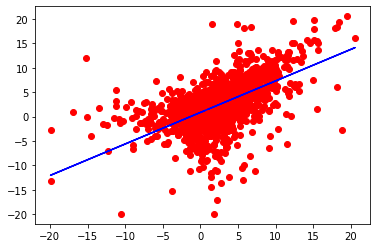

In [123]:
#Looking three past year model
independentVars = []
independentVars.append(IndependentVariable('epspx',1))
'''
independentVars.append(IndependentVariable('epspx',2))
independentVars.append(IndependentVariable('epspx',3))
independentVars.append(IndependentVariable('revt',1))
independentVars.append(IndependentVariable('revt',2))
independentVars.append(IndependentVariable('ebitda',1))
independentVars.append(IndependentVariable('ebitda',2))
independentVars.append(IndependentVariable('dvt',1))
independentVars.append(IndependentVariable('dvt',2))
independentVars.append(IndependentVariable('cshpri',1))
independentVars.append(IndependentVariable('cshpri',2))
'''

RunSimpleRegressionModel('epspx',independentVars)
